## **LSTM with Attention**

Attention weights are to give the RNN more focus on specific parts of the sequence.

* e.g, holidays, weather events,

In [1]:
## 1 single time series (stock price, inventory)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/martinwg/ISA630/refs/heads/master/data/store_sales.csv')
df.head()

,date,sales
0,2013-01-01,0.000000
1,2013-01-02,7417.148000
2,2013-01-03,5873.244001
3,2013-01-04,5919.879001
4,2013-01-05,6318.785010


In [2]:
## set the date to index
df.set_index('date', inplace=True)
df.head()

,sales
date,
2013-01-01,0.000000
2013-01-02,7417.148000
2013-01-03,5873.244001
2013-01-04,5919.879001
2013-01-05,6318.785010


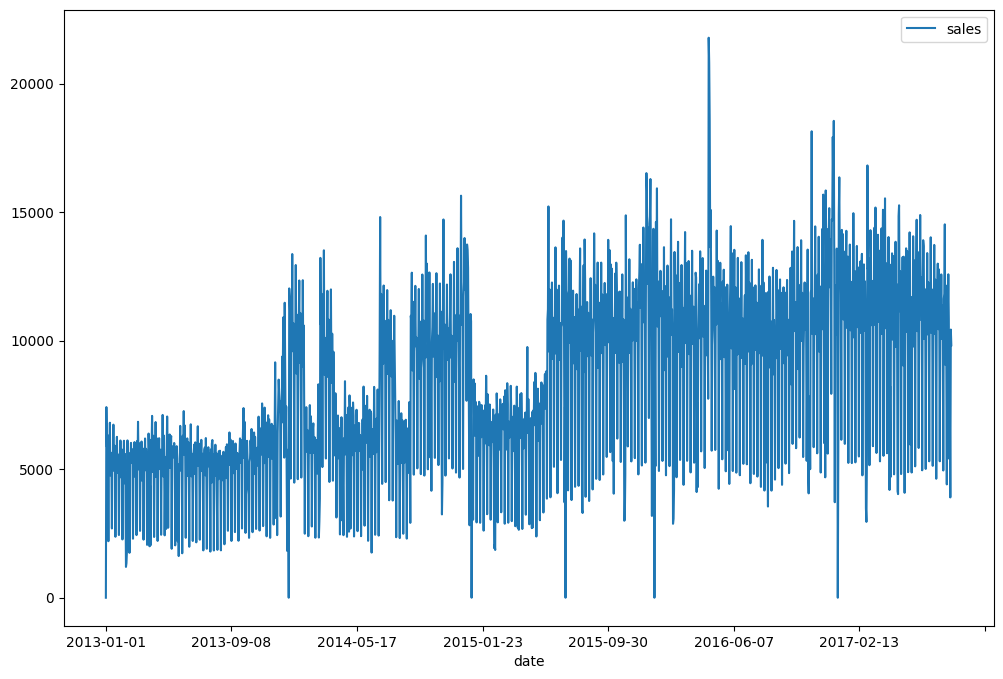

In [4]:
## plot
df.plot(figsize=(12,8))
plt.show()

In [5]:
## standardize the data (MinMaxScaler 0 - 1 or StandardScaler)
from sklearn.preprocessing import StandardScaler

## instance
scaler = StandardScaler()

## fit and transform
## train/test split is usually done earlier
df_scaled = scaler.fit_transform(df)
df_scaled

array([[-2.44929064],
       [-0.2864924 ],
       [-0.73668604],
       ...,
       [-1.31126157],
       [ 0.59300448],
       [ 0.41520106]])

In [6]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
df_scaled.head()

,sales
date,
2013-01-01,-2.449291
2013-01-02,-0.286492
2013-01-03,-0.736686
2013-01-04,-0.723088
2013-01-05,-0.606769


In [9]:
## TimeSeriesGenerator for training and test
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Hyperparams
n_input = 30 ## past 30 days (longer sequence - LSTMs or GRU)
n_future = 1 ## predict next day
batch_size = 16 ##

## 80% training / 20% test
train_size = int(len(df_scaled) * 0.8)
train_data = df_scaled[:train_size].values
test_data = df_scaled[train_size:].values

## create the traingenerator and testgenerator
train_generator = TimeseriesGenerator(train_data, train_data, length=n_input, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=batch_size)

## **Models**



In [11]:
## BiDirectional LSTM
## -first day-------- last day   ||   last day ---------first day
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Input

## build LSTM model
model1 = Sequential()
model1.add(Input(shape = (n_input, 1))) ## 1 time series - 30 lags
model1.add(Bidirectional(LSTM(64, activation = "tanh")))  ## 64 neurons (forget gate, input gate,....) going bidrectionally
model1.add(Dense(10, activation = "relu"))
model1.add(Dense(1))  ## predicting sales next day - linear activation
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,093 (137.08 KB)

 Trainable params: 35,093 (137.08 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
## compile
model1.compile(optimizer = "adam", loss = "mse")

In [14]:
## fit
##
history = model1.fit(train_generator, epochs = 10, validation_data = test_generator)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3248 - val_loss: 0.5218
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.3176 - val_loss: 0.4656
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2956 - val_loss: 0.4986
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.3191 - val_loss: 0.4431
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2651 - val_loss: 0.4084
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.2586 - val_loss: 0.4277
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.2471 - val_loss: 0.4465
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2311 - val_loss: 0.4418
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2049 - val_loss: 0.3911
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2360 - val_loss: 0.3886


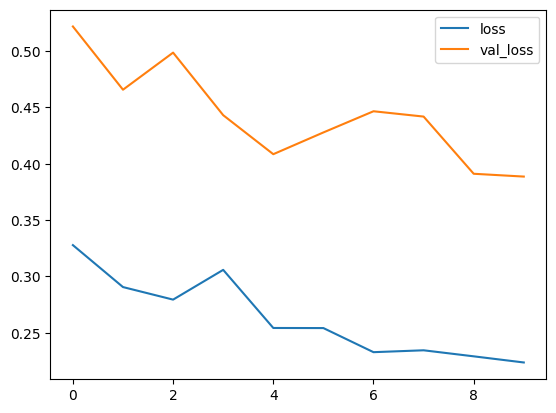

In [15]:
## plot the learning curves
pd.DataFrame(history.history).plot()
plt.show()

You should not try a bi-directional LSTM if the ALL data is not available. Sequences of ONLINE (gets updated often) bi-directional lstms are not very feasible.

In [16]:
## Bidirection GRU
## BiDirectional LSTM
## -first day-------- last day   ||   last day ---------first day
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Input, GRU

## build LSTM model
model1 = Sequential()
model1.add(Input(shape = (n_input, 1))) ## 1 time series - 30 lags
model1.add(Bidirectional(GRU(64, activation = "tanh")))  ## 64 neurons (forget gate, input gate,....) going bidrectionally
model1.add(Dense(10, activation = "relu"))
model1.add(Dense(1))  ## predicting sales next day - linear activation
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,029 (105.58 KB)

 Trainable params: 27,029 (105.58 KB)

 Non-trainable params: 0 (0.00 B)

## **LSTM with Attention**

In [20]:
## Build a BiLSTM with AttentionLayer
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import tensorflow as tf

input_layer = Input(shape = (n_input, 1))
## LSTM encoder
lstm_out = Bidirectional(LSTM(64, return_sequences = True))(input_layer)
## Attention mechanism
attention_scores = Dense(1, activation = "tanh")(lstm_out)  ## 64 sequences (1 attention score for each)
## Attention weights (sum up to 1)
attention_weights = Activation('softmax')(attention_scores)

## Attention Layer (we can use AttentionLayer)
class Attention(Layer):
  def call(self, inputs):
    attention_weights, lstm_out = inputs
    context_vector = tf.reduce_sum(attention_weights * lstm_out, axis = 1)
    return context_vector

## create instance
attention_layer = Attention()
context_vector = attention_layer([attention_weights, lstm_out])

## output layer
output = Dense(1)(context_vector)

## Model
context_vector = Model(inputs = input_layer, outputs = context_vector)
model2 = Model(inputs = input_layer, outputs = output)
model2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 30, 128)   │     33,792 │ input_layer_5[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30, 1)     │        129 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 1)     │          0 │ dense_8[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 128)       │          0 │ activation_3[0][… │
│ (Attention)         │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ attention_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,050 (133.01 KB)

 Trainable params: 34,050 (133.01 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
## compile
model2.compile(optimizer = "adam", loss = "mse")

In [22]:
## fit (BiLSTM with Attention)
model2.fit(train_generator, epochs = 20, validation_data = test_generator)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 30, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.8108 - val_loss: 0.8720
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.6656 - val_loss: 0.8674
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.6169 - val_loss: 1.1617
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7267 - val_loss: 0.8855
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.7327 - val_loss: 0.8659
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7942 - val_loss: 0.9576
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.5319 - val_loss: 0.9202
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.6390 - val_loss: 1.0815
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.5827 - val_loss: 0.9257
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6908 - val_loss: 0.9082
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5071 - val_loss: 0.9248
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5654 - val_l

In [23]:
## predictions
predictions = model2.predict(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 30, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 30, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [24]:
predicted_sales = scaler.inverse_transform(predictions)

In [25]:
actual_sales = scaler.inverse_transform(test_data[n_input:])

In [26]:
from sklearn.metrics import r2_score
r2_score(actual_sales, predicted_sales)

-0.05724472454696161